In [1]:
print("Running as a Jupyter notebook - intended for development only!")
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the HookedTransformer code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

import plotly.io as pio
pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Running as a Jupyter notebook - intended for development only!
Using renderer: notebook_connected


/var/folders/l8/sk6bzryx0zl510jmp6_ywxd80000gn/T/ipykernel_53284/2694705499.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/var/folders/l8/sk6bzryx0zl510jmp6_ywxd80000gn/T/ipykernel_53284/2694705499.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

In [4]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
torch.set_grad_enabled(False)

In [5]:
from neel_plotly import line, scatter, imshow, histogram

### Load 8L 8H Model and Convert to Transformer Lens

In [6]:
def convert_to_transformer_lens_format(in_sd, n_layers=8, n_heads=8):
    out_sd = {}
    out_sd["pos_embed.W_pos"] = in_sd["pos_emb"].squeeze(0)
    out_sd["embed.W_E"] = in_sd["tok_emb.weight"]

    out_sd["ln_final.w"] = in_sd["ln_f.weight"]
    out_sd["ln_final.b"] = in_sd["ln_f.bias"]
    out_sd["unembed.W_U"] = in_sd["head.weight"].T

    for layer in range(n_layers):
        out_sd[f"blocks.{layer}.ln1.w"] = in_sd[f"blocks.{layer}.ln1.weight"]
        out_sd[f"blocks.{layer}.ln1.b"] = in_sd[f"blocks.{layer}.ln1.bias"]
        out_sd[f"blocks.{layer}.ln2.w"] = in_sd[f"blocks.{layer}.ln2.weight"]
        out_sd[f"blocks.{layer}.ln2.b"] = in_sd[f"blocks.{layer}.ln2.bias"]

        out_sd[f"blocks.{layer}.attn.W_Q"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.query.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_Q"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.query.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_K"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.key.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_K"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.key.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_V"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.value.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_V"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.value.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_O"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.proj.weight"], "d_model (head d_head) -> head d_head d_model", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_O"] = in_sd[f"blocks.{layer}.attn.proj.bias"]

        out_sd[f"blocks.{layer}.mlp.b_in"] = in_sd[f"blocks.{layer}.mlp.0.bias"]
        out_sd[f"blocks.{layer}.mlp.W_in"] = in_sd[f"blocks.{layer}.mlp.0.weight"].T
        out_sd[f"blocks.{layer}.mlp.b_out"] = in_sd[f"blocks.{layer}.mlp.2.bias"]
        out_sd[f"blocks.{layer}.mlp.W_out"] = in_sd[f"blocks.{layer}.mlp.2.weight"].T
    
    return out_sd

## Make sure to change path

In [7]:
layers, heads = 8,8
# Change this path
path = f"../EWOthello/ckpts/DeanKLi_GPT_Synthetic_{layers}L{heads}H/GPT_Synthetic_{layers}Layers_{heads}Heads.ckpt"
synthetic_checkpoint = torch.load(path, map_location='cpu')
for name, param in synthetic_checkpoint.items():
    if name.startswith("blocks.0") or not name.startswith("blocks"):
        print(name, param.shape)

cfg = HookedTransformerConfig(
    n_layers = layers,
    d_model = 512,
    d_head = 64,
    n_heads = heads,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model = HookedTransformer(cfg)


model.load_and_process_state_dict(convert_to_transformer_lens_format(synthetic_checkpoint, n_layers=layers, n_heads=heads))


pos_emb torch.Size([1, 59, 512])
tok_emb.weight torch.Size([61, 512])
blocks.0.ln1.weight torch.Size([512])
blocks.0.ln1.bias torch.Size([512])
blocks.0.ln2.weight torch.Size([512])
blocks.0.ln2.bias torch.Size([512])
blocks.0.attn.mask torch.Size([1, 1, 59, 59])
blocks.0.attn.key.weight torch.Size([512, 512])
blocks.0.attn.key.bias torch.Size([512])
blocks.0.attn.query.weight torch.Size([512, 512])
blocks.0.attn.query.bias torch.Size([512])
blocks.0.attn.value.weight torch.Size([512, 512])
blocks.0.attn.value.bias torch.Size([512])
blocks.0.attn.proj.weight torch.Size([512, 512])
blocks.0.attn.proj.bias torch.Size([512])
blocks.0.mlp.0.weight torch.Size([2048, 512])
blocks.0.mlp.0.bias torch.Size([2048])
blocks.0.mlp.2.weight torch.Size([512, 2048])
blocks.0.mlp.2.bias torch.Size([512])
ln_f.weight torch.Size([512])
ln_f.bias torch.Size([512])
head.weight torch.Size([61, 512])


### Load Othello Content
Boring setup code to load in 100K sample Othello games, the linear probe, and some utility functions

In [8]:
from EWOthello.othello_world.mechanistic_interpretability.mech_interp_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState
OTHELLO_ROOT = Path("../EWOthello/othello_world/")

board_seqs_int = torch.tensor(np.load(OTHELLO_ROOT/"board_seqs_int_small.npy"), dtype=torch.long)
board_seqs_string = torch.tensor(np.load(OTHELLO_ROOT/"board_seqs_string_small.npy"), dtype=torch.long)

num_games, length_of_game = board_seqs_int.shape
print("Number of games:", num_games,)
print("Length of game:", length_of_game)

Number of games: 100000
Length of game: 60


In [9]:
stoi_indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
]
alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i//8]}{i%8}"


board_labels = list(map(to_board_label, stoi_indices))

### Running the Model
Keep in mind that state 61 corresponds to passing (not making a move)

In [10]:
moves_int = board_seqs_int[0, :30]

# This is implicitly converted to a batch of size 1
logits = model(moves_int)
print("logits:", logits.shape)

logit_vec = logits[0, -1]
log_probs = logit_vec.log_softmax(-1)
# Remove passing
log_probs = log_probs[1:]
assert len(log_probs)==60

temp_board_state = torch.zeros(64, device=logit_vec.device)
# Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 13.
temp_board_state[stoi_indices] = log_probs

logits: torch.Size([1, 30, 61])


In [11]:
def plot_square_as_board(state, diverging_scale=True, **kwargs):
    """Takes a square input (8 by 8) and plot it as a board. Can do a stack of boards via facet_col=0"""
    if diverging_scale:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="RdBu", color_continuous_midpoint=0., aspect="equal", **kwargs)
    else:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="Blues", color_continuous_midpoint=None, aspect="equal", **kwargs)
plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=False, title="Kenneths 8L8H Log Probs")

In [12]:
plot_single_board(int_to_label(moves_int))

### Exploring Gameplay

In [13]:
board = OthelloBoardState()
board.update(to_string(moves_int))
plot_square_as_board(board.state, title="Example Board State (+1 is Black, -1 is White)")

In [14]:
plot_single_board(int_to_label(moves_int))

In [15]:
print("Valid moves:", string_to_label(board.get_valid_moves()))

Valid moves: ['A3', 'A5', 'A6', 'B2', 'C7', 'D2', 'E6', 'F7', 'G6', 'H2', 'H3', 'H4', 'H6']


In [16]:
num_games = 50
focus_games_int = board_seqs_int[:num_games]
focus_games_string = board_seqs_string[:num_games]

In [17]:
def one_hot(list_of_ints, num_classes=64):
    out = torch.zeros((num_classes,), dtype=torch.float32)
    out[list_of_ints] = 1.
    return out
focus_states = np.zeros((num_games, 60, 8, 8), dtype=np.float32)
focus_valid_moves = torch.zeros((num_games, 60, 64), dtype=torch.float32)
for i in (range(num_games)):
    board = OthelloBoardState()
    for j in range(60):
        board.umpire(focus_games_string[i, j].item())
        focus_states[i, j] = board.state
        focus_valid_moves[i, j] = one_hot(board.get_valid_moves())
print("focus states:", focus_states.shape)
print("focus_valid_moves", focus_valid_moves.shape)


focus states: (50, 60, 8, 8)
focus_valid_moves torch.Size([50, 60, 64])


In [18]:
focus_games_int[0, :].shape

torch.Size([60])

### Visualizing Attention Patterns for One Specific Game

In [19]:
moves = 15
sample_game = focus_games_int[0, :-1]
focus_logits, focus_cache = model.run_with_cache(sample_game)

In [20]:
attention_patterns = []
for i in range(layers):
    attention_patterns.append(focus_cache["pattern", i, "attn"][0])

In [21]:
plot_single_board(int_to_label(sample_game))

In [52]:
attention_patterns[0].shape

torch.Size([8, 59, 59])

In [144]:
print("Layer 1 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[0])

Layer 1 Head Attention Patterns:


In [141]:
print("Layer 2 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[1])

Layer 2 Head Attention Patterns:


In [140]:
print("Layer 3 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[2])

Layer 3 Head Attention Patterns:


In [139]:
print("Layer 4 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[3])

Layer 4 Head Attention Patterns:


In [138]:
print("Layer 5 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[4])

Layer 5 Head Attention Patterns:


In [137]:
print("Layer 6 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[5])

Layer 6 Head Attention Patterns:


In [135]:
print("Layer 7 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[6])

Layer 7 Head Attention Patterns:


In [134]:
print("Layer 8 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=[str(i) for i in range(59)], attention=attention_patterns[7])

Layer 8 Head Attention Patterns:


In [94]:
aggregate = torch.empty(8, 8, 59, 59)

In [40]:
attention_pattern = focus_cache["pattern", 0][0][1]
their_mask = torch.zeros(attention_pattern.shape, dtype=bool)
my_mask = torch.zeros(attention_pattern.shape, dtype=bool)

for i in range(1,len(my_mask)):
    their_mask[i][i%2::2] = True
    my_mask[i][(i+1)%2::2] = True

def last_token_detector(cache: ActivationCache, game: int) -> List[str]:
    attn_heads = [f"{game}.{layer}.{head}"
                  for layer in range(model.cfg.n_layers)
                  for head in range(model.cfg.n_heads)
                  if cache["pattern", layer][0][head].diagonal().mean() > 0.7]
    return attn_heads

def first_token_detector(cache: ActivationCache, game: int) -> List[str]:
    attn_heads = [f"{game}.{layer}.{head}"
                  for layer in range(model.cfg.n_layers)
                  for head in range(model.cfg.n_heads)
                  if cache["pattern", layer][0][head][:, 0].mean() > 0.7]
    return attn_heads

def my_token_detector(cache: ActivationCache, game: int) -> List[str]:
    attn_heads=[]
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][0][head]
            score = (attention_pattern * my_mask).sum(dim=1).mean()
            if score > 0.7:
                attn_heads.append(f"{game}.{layer}.{head}")
    return attn_heads

def their_token_detector(cache: ActivationCache, game: int) -> List[str]:
    attn_heads=[]
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][0][head]
            score = (attention_pattern * their_mask).sum(dim=1).mean()
            if score > 0.7:
                attn_heads.append(f"{game}.{layer}.{head}")
    return attn_heads

def update_aggregate(aggregate, cache):
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            aggregate[layer][head] += cache["pattern", layer][0][head]
    return aggregate

In [41]:
from tqdm import tqdm


In [66]:
def find_all_heads(games: torch.Tensor):
    aggregate = torch.empty(8, 8, 59, 59)
    ltd, ftd, mtd, ttd, no_head = set(), set(), set(), set(), set()
    for i, game in enumerate(tqdm(games)):
        focus_logits, focus_cache = model.run_with_cache(game)
        ltd.update(last_token_detector(focus_cache, i))
        ftd.update(first_token_detector(focus_cache, i))
        mtd.update(my_token_detector(focus_cache, i))
        ttd.update(their_token_detector(focus_cache, i))
        aggregate = update_aggregate(aggregate, focus_cache)
        if (i+1) % 10000 == 0:
            print(f"Sizes of Last Token Detector: {len(ltd)}, First Token Detector: {len(ftd)}, My Token Detector: {len(mtd)}, Their Token Detector: {len(ttd)}")

    all_special = ltd.union(ftd).union(mtd).union(ttd)
    no_head = {f"{i}.{layer}.{head}"
               for i in range(len(games))
               for layer in range(model.cfg.n_layers)
               for head in range(model.cfg.n_heads)
               if f"{i}.{layer}.{head}" not in all_special}

    return aggregate, ltd, ftd, mtd, ttd, no_head

In [67]:
aggregate, ltd, ftd, mtd, ttd, no_head = find_all_heads(board_seqs_int[:, :-1])
print(f"Sizes of Last Token Detector: {len(ltd)}, First Token Detector: {len(ftd)}, My Token Detector: {len(mtd)}, Their Token Detector: {len(ttd)}, None: {len(no_head)}")

 10%|███████████▎                                                                                                     | 10007/100000 [04:07<37:08, 40.38it/s]

Sizes of Last Token Detector: 18505, First Token Detector: 43597, My Token Detector: 267588, Their Token Detector: 208989


 20%|██████████████████████▌                                                                                          | 20004/100000 [08:16<36:48, 36.23it/s]

Sizes of Last Token Detector: 37170, First Token Detector: 87355, My Token Detector: 535212, Their Token Detector: 417970


 30%|█████████████████████████████████▉                                                                               | 30004/100000 [12:26<29:03, 40.14it/s]

Sizes of Last Token Detector: 55886, First Token Detector: 130984, My Token Detector: 802750, Their Token Detector: 627159


 40%|█████████████████████████████████████████████▏                                                                   | 40005/100000 [16:53<25:34, 39.10it/s]

Sizes of Last Token Detector: 74758, First Token Detector: 175045, My Token Detector: 1070200, Their Token Detector: 836141


 50%|████████████████████████████████████████████████████████▌                                                        | 50006/100000 [21:21<21:36, 38.57it/s]

Sizes of Last Token Detector: 93426, First Token Detector: 218517, My Token Detector: 1337956, Their Token Detector: 1045466


 60%|███████████████████████████████████████████████████████████████████▊                                             | 60005/100000 [25:50<17:43, 37.62it/s]

Sizes of Last Token Detector: 112100, First Token Detector: 262475, My Token Detector: 1605371, Their Token Detector: 1254338


 70%|███████████████████████████████████████████████████████████████████████████████                                  | 70005/100000 [30:18<13:19, 37.50it/s]

Sizes of Last Token Detector: 130794, First Token Detector: 306104, My Token Detector: 1872876, Their Token Detector: 1463478


 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 80005/100000 [34:46<08:44, 38.13it/s]

Sizes of Last Token Detector: 149467, First Token Detector: 349702, My Token Detector: 2140345, Their Token Detector: 1672644


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 90005/100000 [39:15<04:41, 35.53it/s]

Sizes of Last Token Detector: 168190, First Token Detector: 393423, My Token Detector: 2407763, Their Token Detector: 1881593


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [43:44<00:00, 38.10it/s]


Sizes of Last Token Detector: 186865, First Token Detector: 436741, My Token Detector: 2675553, Their Token Detector: 2090828
Sizes of Last Token Detector: 186865, First Token Detector: 436741, My Token Detector: 2675553, Their Token Detector: 2090828, None: 1196879


In [70]:
!pip install venn

  Using cached venn-0.1.3-py3-none-any.whl


In [159]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [105]:
fig = ax.get_figure()

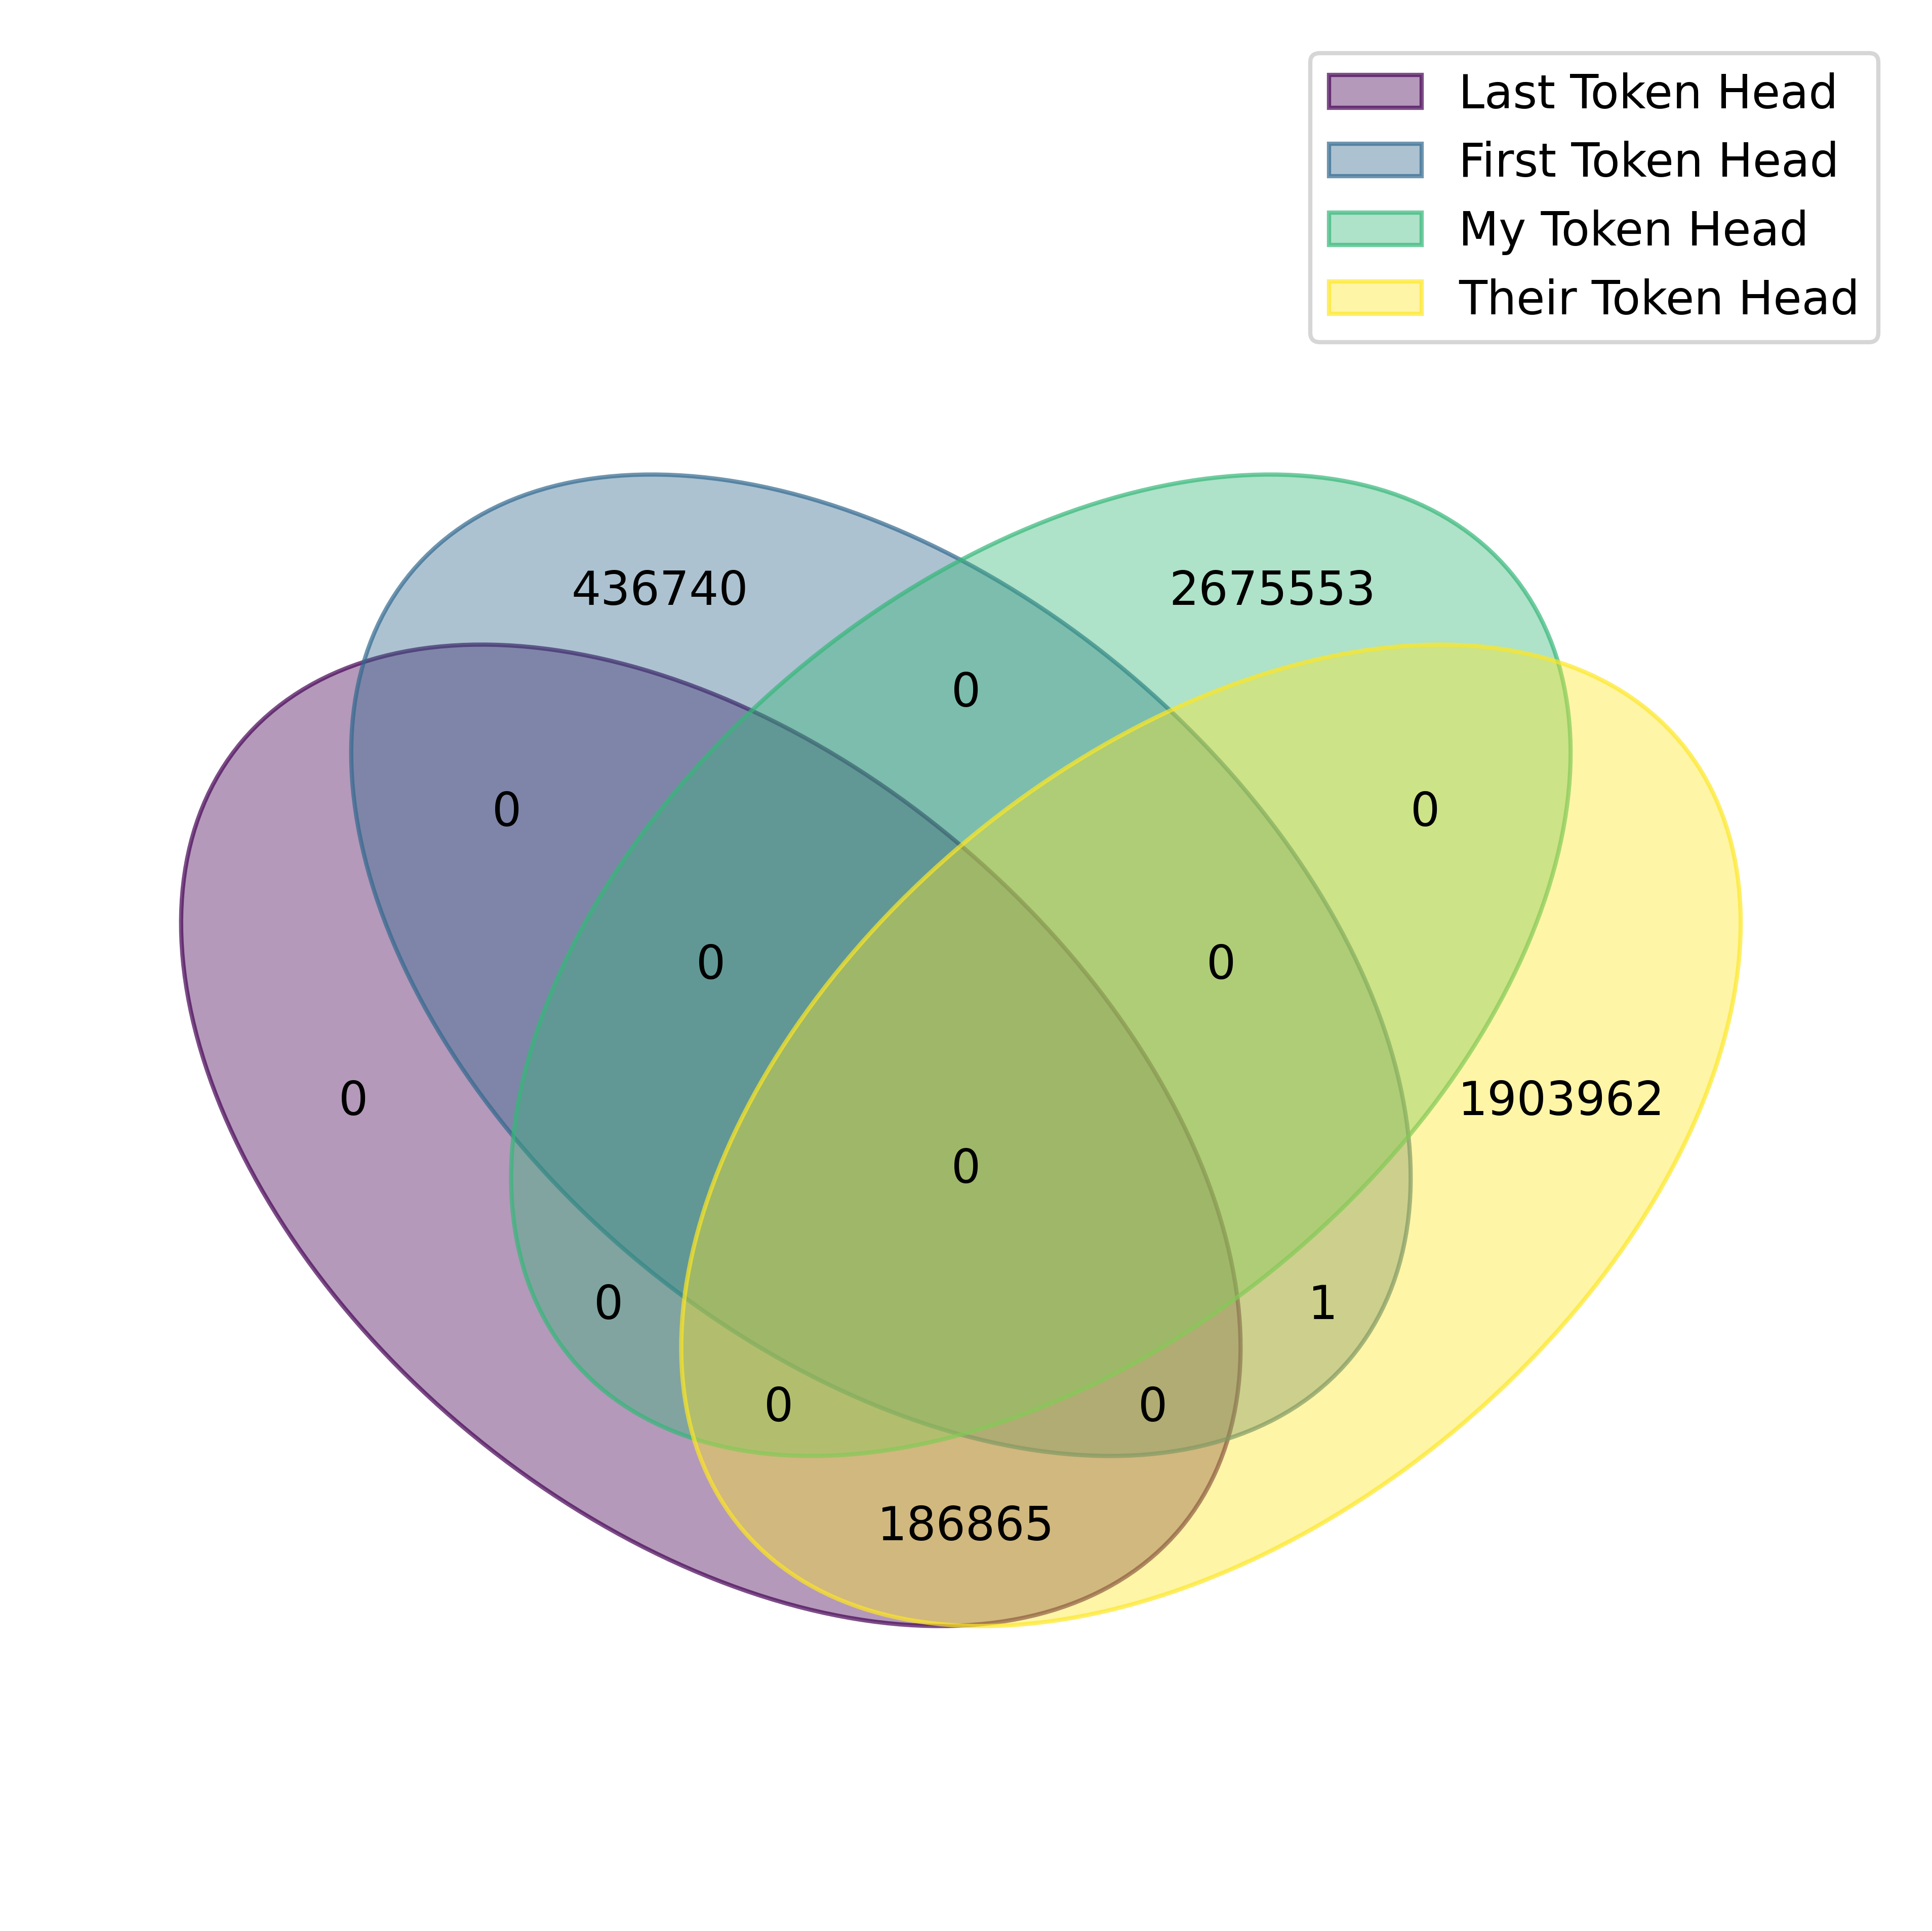

In [107]:
from venn import venn
circuit_data = {
    "Last Token Head": ltd,
    "First Token Head": ftd,
    "My Token Head": mtd,
    "Their Token Head": ttd
}
ax = venn(circuit_data, fontsize=11)
fig = ax.get_figure()
fig.savefig('../images/circuit_counts.png', bbox_inches='tight')

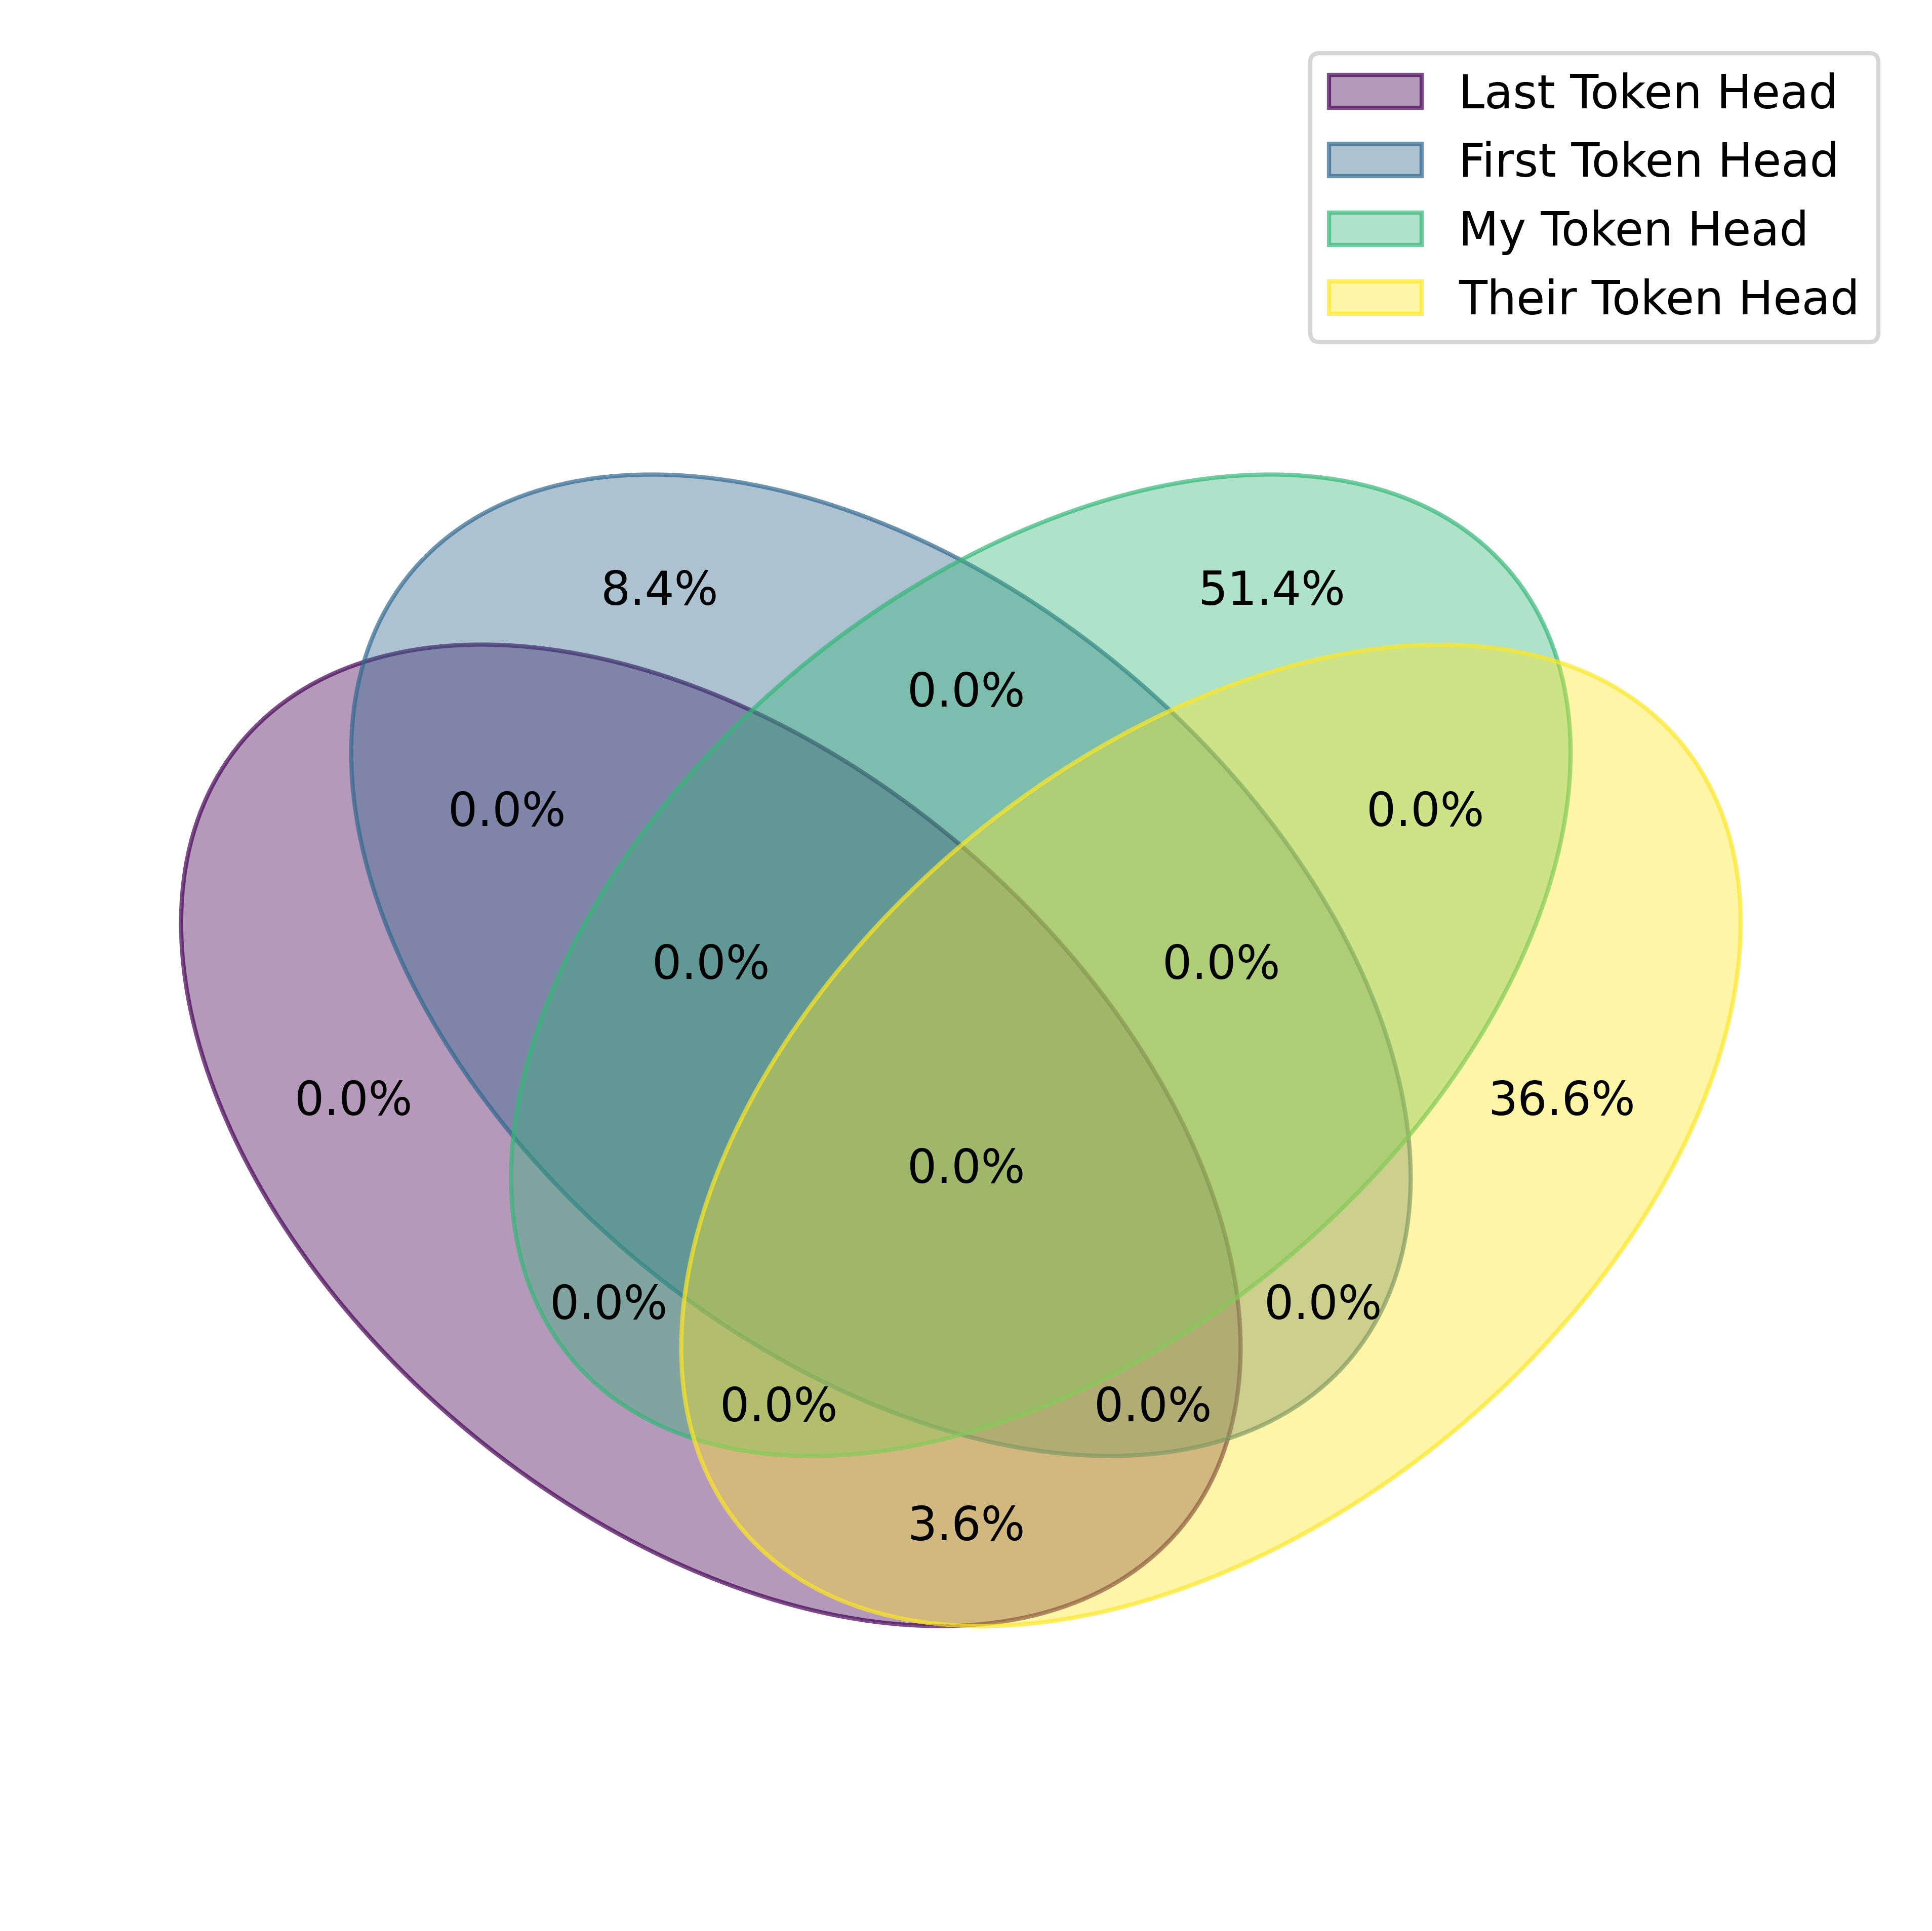

In [108]:
from venn import venn
circuit_data = {
    "Last Token Head": ltd,
    "First Token Head": ftd,
    "My Token Head": mtd,
    "Their Token Head": ttd
}
ax = venn(circuit_data, fmt="{percentage:.1f}%", fontsize=11)
fig = ax.get_figure()
fig.savefig('../images/circuit_pct.png', bbox_inches='tight')

In [81]:
attention_patterns = aggregate / 100000

In [85]:
attention_patterns[attention_patterns < 1e-5] = 0

In [145]:
import matplotlib.pyplot as plt

In [148]:
import EWOthello.utils.plot_helpers as plt_util


In [186]:
mpl.rcParams['figure.dpi'] = 1200
fig = plt.figure(figsize=(2 * heads, 2 * layers))
ax = plt_util.addAxis(fig,heads, layers)
iter = 0
for i in range(layers):
    for j in range(heads):
        attn = attention_patterns[i][j]
        ax[iter].imshow(attn, vmin=0, vmax=1, cmap='Greys')
        ax[iter].set_axis_off()
        if iter % 8 == 0:
            ax[iter].set_title(f"Layer {i+1}").set_position([0, 1.05])
        iter+=1
# plt.setp(ax[:], ylabel='y axis label')
fig.tight_layout()
fig.savefig('../images/attention_dist.png', bbox_inches='tight', dpi=1200)

SyntaxError: keyword argument repeated (1056151190.py, line 15)